In [1]:
# If this notebook is in a subdirectory of the project's root,
# update the PYTHONPATH to be able to import as usual
import os, sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.append(project_root)

In [2]:
# Standard Imports
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.stats import sem

# Project Imports
from model.hnn import HNN, CorrectedHNN
from model.loss import choose_scheme
from model.data import get_t_eval

from train import setup
from utils import save_path
from metrics import load_model, integrate_trajectory, calc_mse, load_mse

In [3]:
hs = np.array([0.8, 0.4, 0.2, 0.1, 0.05])
methods = ['euler-forw', 'euler-symp', 'midpoint']
SAVE_DIR_PREFIX = '/results/experiment-'

## Outsource the integration for trajectories 

In [4]:
def calc_trajectory(args, t_span, same_method=False, corrected=False, t_eval=None, y0=None):
    model, args = load_model(args, corrected, '/results/experiment-')
    
    if y0 is None:
        y0 = args.data_class.static_initial_value()
    
    y, t = integrate_trajectory(model, args, t_span, y0, same_method, t_eval=t_eval)
    
    vf = get_predicted_vector_field(model, args)

    return vf, y, t

## Plotting Utilities in phase space, etc.

In [5]:
# PLOTTING UTILITIES
def plot_traj_colortime(ax, y, LS=300):
    #for i, l in enumerate(np.array_split(y, LS)):
        #color = (float(i) / LS, 0, 1 - float(i) / LS)
        #ax.plot(l[:, 0], l[:, 1], color=color, linewidth=1)
        #ax.scatter(l[:, 0], l[:, 1], color=color, s=1)
    ax.plot(y[:, 0], y[:, 1], color=(1, 0, 0), linewidth=1.5)

def plot_traj_label(ax, y, label):
    ax.plot(y[:, 0], y[:, 1], label=label, linewidth=1.5)
    
def plot_vector_field(ax, vf):
    ax.quiver(vf['x'][:, 0], vf['x'][:, 1], vf['y'][:, 0], vf['y'][:, 1],
              cmap='gray_r', scale=30, width=6e-3, color=(.5, .5, .5))
    
def set_legend(ax, legend_loc='lower right'):
    legend = ax.legend(loc=legend_loc)
    legend.get_frame().set_facecolor('0.9')  # fill the legend dark grey
    legend.get_frame().set_linewidth(0.0)  # remove the black border

## Begin plotting code

In [6]:
from visualize import *
mpl.rcParams.update(params)
%matplotlib inline

# The visualize model defines default_args with name='pendulum'
args = default_args | {'name': 'pendulum', 'h': 0.4}
args = setup(args, save_dir_prefix=SAVE_DIR_PREFIX)

t_span = (0, 300)
t_eval = get_t_eval(t_span, min(hs))

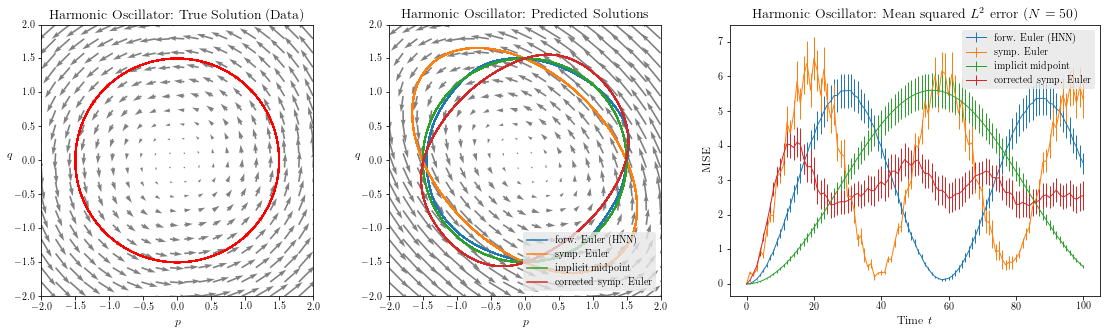

In [11]:
args = default_args | {'name': 'spring', 'h': 0.8}
args = setup(args, save_dir_prefix=SAVE_DIR_PREFIX)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5/golden_ratio+11, 5), gridspec_kw={'width_ratios': [1, 1, 1.3]})  # multiply with golden_ratio
fig.subplots_adjust(wspace=0.2, hspace=0.1)

# FIRST PLOT: TRUE VECTOR FIELD AND SOLUTION
data_loader = args.data_class(args.h, args.noise)
boundary = data_loader.phase_space_boundaries()

#y0 = np.array([0, 2.5])
y0 = np.array([0, 1.5])
#y0 = data_loader.static_initial_value()  # [0., 3.]

exact_vf = data_loader.get_analytic_field()
exact_y, exact_t = data_loader.get_trajectory(t_span=t_span, y0=y0, t_eval=t_eval)

plot_vector_field(ax1, exact_vf)
plot_traj_colortime(ax1, exact_y)
phase_space_helper(ax1, boundary, f"{print_name[args.name]}: True Solution (Data)", aspect_equal=True)

# SECOND PLOT: PREDICTED FIELD + ALL PREDICTED TRAJECTORIES
for method in methods:
    vf, y, t = calc_trajectory(args | {'loss_type': method}, t_span, t_eval=t_eval, y0=y0)
    
    plot_traj_label(ax2, y, print_method[method])
    
    if method == 'euler-symp':
        # Ensure that the same vector field is only plotted one time.
        plot_vector_field(ax2, vf)
        #plot_vf = False

# Use corrected symp Euler
vf, y, t = calc_trajectory(args | {'loss_type': 'euler-symp'}, t_span, corrected=True, t_eval=t_eval, y0=y0)
plot_traj_label(ax2, y, 'corrected ' + print_method['euler-symp'])
        
phase_space_helper(ax2, boundary, f"{print_name[args.name]}: Predicted Solutions", aspect_equal=True)
set_legend(ax2)


#### PLOT MSEs ADDITIONALLY
for method in methods:
    mse_dict = load_mse(args | {'loss_type': method})
    mse, stderr = mse_dict['mse'], mse_dict['stderr']
    mod_t_eval = mse_dict['t_eval']
        
    #plt.plot(t_eval, mse, label=print_method[method]')
    ax3.errorbar(mod_t_eval, mse, yerr=stderr, label=print_method[method], linewidth=1)

# Euler symp corrected
mse_dict = load_mse(args | {'loss_type': 'euler-symp'}, corrected=True)
mse, stderr = mse_dict['mse'], mse_dict['stderr']
mod_t_eval = mse_dict['t_eval']
ax3.errorbar(mod_t_eval, mse, yerr=stderr,
             label='corrected ' + print_method['euler-symp'], linewidth=1)

N = 50 #mse_dict['N']

# Configure Plot    
ax3.set_xlabel("Time $t$")
ax3.set_ylabel("MSE")
ax3.set_title(f"{print_name[args.name]}: Mean squared $L^2$ error ($N={N}$)")
set_legend(ax3, legend_loc='upper right')
# END PLOT MSEs 

plt.savefig(f"phase-space-and-mses-{args.name}-h{args.h}.pdf", format='pdf', bbox_inches='tight')

## Plot a trajectory with a broken axis

Following the [example](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html) of Matplotlib for broken axes.

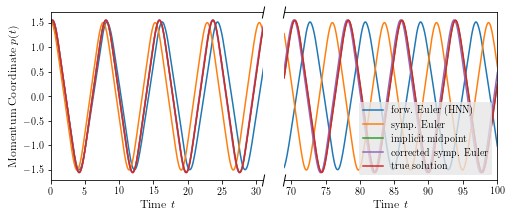

In [12]:
args = default_args | {'name': 'pendulum', 'h': 0.4}
args = setup(args, save_dir_prefix=SAVE_DIR_PREFIX)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 5*golden_ratio))  
fig.subplots_adjust(wspace=0.1)

# "Random" y0
y0 = np.array([1.5, -0.4])

# True Solution
data_loader = args.data_class(args.h, args.noise)
exact_y, exact_t = data_loader.get_trajectory(t_span=t_span, y0=y0, t_eval=t_eval)

# ONE PLOT OF P(t) FOR EACH SOLUTION
for method in methods:
    vf, y, t = calc_trajectory(args | {'loss_type': method}, t_span, t_eval=t_eval, y0=y0)
    
    # y[:, 0] selects all points in time, but only the p coordinate
    ax1.plot(t, y[:, 0])
    ax2.plot(t, y[:, 0], label=print_method[method])
    
# Manually add the solution predicted by Euler symplectic CORRECTED
vf, y, t = calc_trajectory(args | {'loss_type': 'euler-symp'}, t_span, corrected=True, t_eval=t_eval, y0=y0)
ax1.plot(t, y[:, 0], color='C4')
ax2.plot(t, y[:, 0], label='corrected ' + print_method['euler-symp'], color='C4')

# Manually add the true solution
ax1.plot(exact_t, exact_y[:, 0], color='C3')
ax2.plot(exact_t, exact_y[:, 0], label='true solution', color='C3')

# Zoom in on the different data, leave extra margins so the slashes don't cut the ticks
ax1.set_xlim(0, 31)
ax2.set_xlim(69, 100)
#ax2.set_xlim(149, 180)

# Hide the spines between ax and ax2
ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax2.yaxis.set_ticks_position('none')

# Make the slashed lines on the axes
d = .2  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

ax1.set_xlabel("Time $t$")
ax2.set_xlabel("Time $t$")
ax1.set_ylabel("Momentum Coordinate $p(t)$")
set_legend(ax2)

fig.savefig(f"trajectory-sample-{args.name}-h{args.h}.pdf", format='pdf', bbox_inches='tight')

## Plot the mean squared error between coordinates

Averaged over many trajectories calculated from random initial points.

### Code for calculation (will save pickle objects, see metrics.calc_mse)

In [18]:
args = default_args | {'name': 'spring', 'h': 0.2}
args = setup(args, save_dir_prefix='/results/experiment-')

mod_t_span = (0, 100)
mod_t_eval = get_t_eval(mod_t_span, 1)
N=50

for method in methods:
    print(f"Calculating MSE for {method}...")
    calc_mse(args | {'loss_type': method}, mod_t_span, t_eval=mod_t_eval, N=N)  # same_method=False, corrected=False

print(f"Calculating MSE for corrected euler-symp...")
calc_mse(args | {'loss_type': 'euler-symp'}, mod_t_span, t_eval=mod_t_eval, N=N, corrected=True)

Calculating MSE for euler-forw...
Calculating MSE for euler-symp...
Calculating MSE for midpoint...
Calculating MSE for corrected euler-symp...


### Code for independent visualization of the resulting data

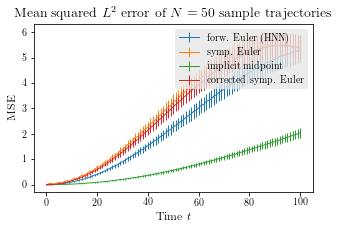

In [17]:
args = default_args | {'name': 'spring', 'h': 0.4}
args = setup(args, save_dir_prefix='/results/experiment-')

fig = plt.figure(figsize=(5, 5*golden_ratio))

for method in methods:
    mse_dict = load_mse(args | {'loss_type': method})
    mse, stderr = mse_dict['mse'], mse_dict['stderr']
    mod_t_eval = mse_dict['t_eval']
        
    #plt.plot(t_eval, mse, label=print_method[method]')
    plt.errorbar(mod_t_eval, mse, yerr=stderr, label=print_method[method], linewidth=1)

# Euler symp corrected
mse_dict = load_mse(args | {'loss_type': 'euler-symp'}, corrected=True)
mse, stderr = mse_dict['mse'], mse_dict['stderr']
mod_t_eval = mse_dict['t_eval']
plt.errorbar(mod_t_eval, mse, yerr=stderr,
             label='corrected ' + print_method['euler-symp'], linewidth=1)

N = 50 #mse_dict['N']

# Configure Plot    
plt.xlabel("Time $t$")
plt.ylabel("MSE")
plt.title(f"Mean squared $L^2$ error of $N={N}$ sample trajectories")
set_legend(plt, legend_loc='upper right')

plt.savefig(f"mses-{args.name}-h{args.h}.pdf", format='pdf', bbox_inches='tight')